## **📥 Environment Setup and Imports**


In [3]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [4]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505215 sha256=6deb4055f67fc415e698f8f2a0220d60794a98ed52708f0820926e02a36830f8
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans

## **🔍 Load and Explore Data**

In [3]:
df = pd.read_csv('ratings.csv', on_bad_lines='skip')

In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
df.drop('timestamp', axis=1, inplace=True)

In [ ]:
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
#plot avg ratings
average_ratings_users = df.groupby(['userId'])['rating'].mean().reset_index().sort_values(by="rating")
average_ratings_users

,userId,rating
441,442,1.275000
138,139,2.144330
507,508,2.145833
152,153,2.217877
566,567,2.245455
...,...,...
29,30,4.735294
24,25,4.807692
514,515,4.846154
250,251,4.869565


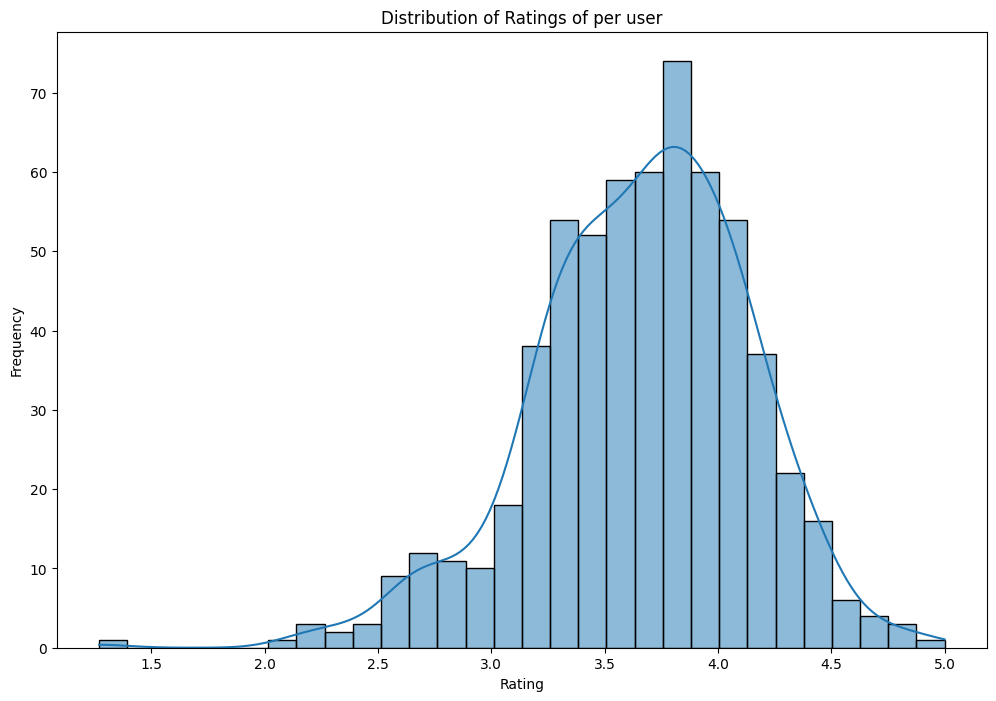

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(round(average_ratings_users["rating"], 2), bins=30, kde=True);
plt.title('Distribution of Ratings of per user')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Here we can conclude that most ratings per user mostly in the range of 3.5 to 4 stars

In [ ]:
average_ratings_movie = df.groupby(['movieId'])['rating'].mean().reset_index().sort_values(by="rating")
average_ratings_movie

,movieId,rating
5541,26696,0.5
2685,3604,0.5
4872,7312,0.5
9099,145724,0.5
7280,76030,0.5
...,...,...
2876,3851,5.0
8734,128087,5.0
5862,33138,5.0
7960,96608,5.0


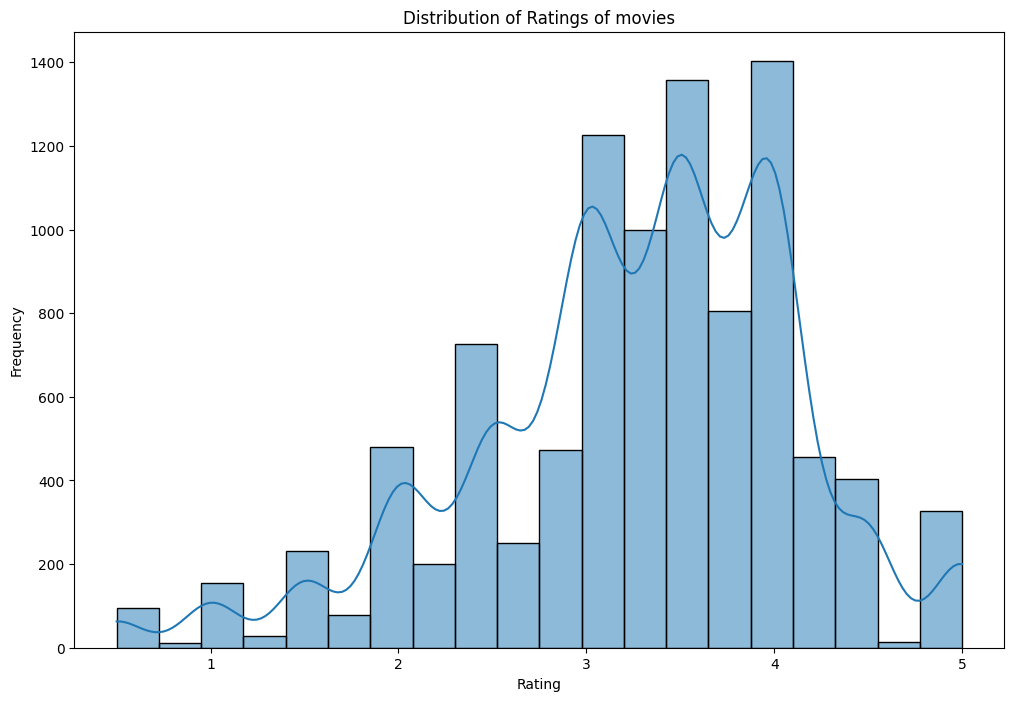

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(round(average_ratings_movie["rating"], 1), bins=20, kde=True);
plt.title('Distribution of Ratings of movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Here we can conclude that most ratings per movie mostly in the range of 3 to 4 stars

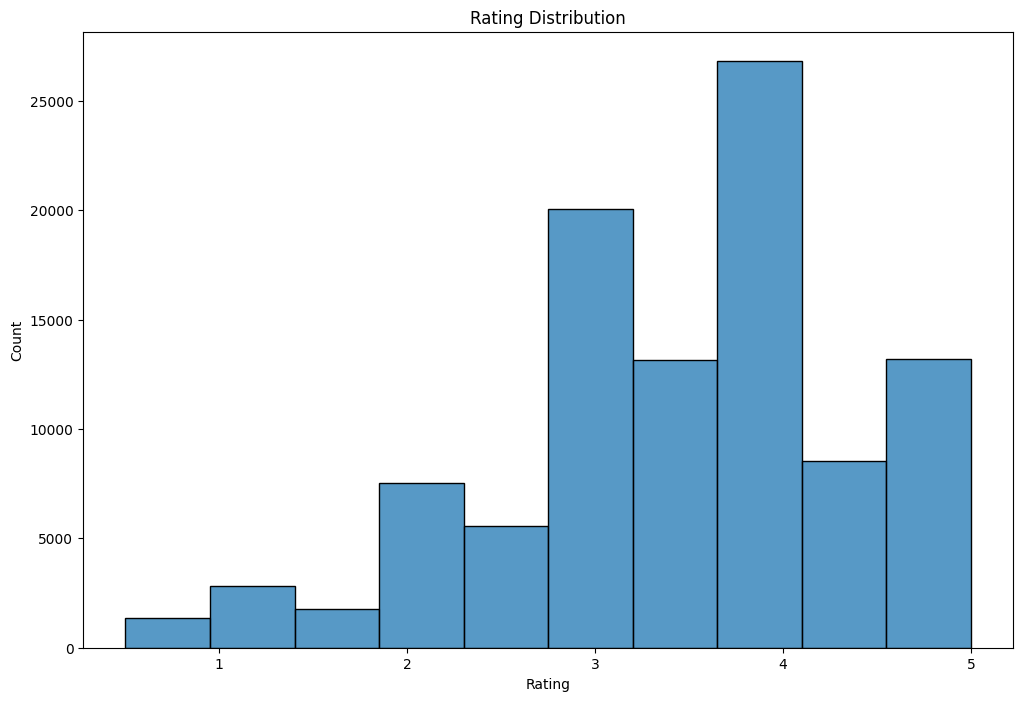

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(df['rating'], bins=10)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
#Most active usesrs
df['userId'].value_counts().head()

,count
userId,
414,2698
599,2478
474,2108
448,1864
274,1346


In [ ]:
#Most rates movies
df['movieId'].value_counts().head()

,count
movieId,
356,329
318,317
296,307
593,279
2571,278


In [ ]:
#generate utility matrix
user_item_matrix = df.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **🧪 Testing Different Model Trials**

In [ ]:
#reasing and scaling data
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [ ]:
#Split data into train and test
trsinset , testset = train_test_split(data, test_size=0.2)
sim_options = {
    "name": "pearson",
    "user_based": False,
}

In [ ]:
#Build model
k = 10
knn_model = KNNWithMeans(k=k, sim_options=sim_options)

In [ ]:
#fitting model
knn_model.fit(trsinset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
#test model
predictions = knn_model.test(testset)

In [ ]:
#get the top n
import collections
def get_top_n(predictions, n=k):
    top_n = collections.defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(predictions, n=k)

for uid, user_ratings in list(top_n.items())[:3]:
    print(f"\nUser {uid} Top 5 Recommendations:")
    for iid, est_rating in user_ratings:
        print(f"  Movie {iid} with predicted rating {est_rating:.2f}")


User 464 Top 5 Recommendations:
  Movie 5952 with predicted rating 4.61
  Movie 1210 with predicted rating 4.60
  Movie 858 with predicted rating 4.50
  Movie 296 with predicted rating 4.48
  Movie 33493 with predicted rating 4.37
  Movie 3578 with predicted rating 4.24
  Movie 110 with predicted rating 4.22
  Movie 356 with predicted rating 4.19
  Movie 1240 with predicted rating 4.03
  Movie 54286 with predicted rating 4.02

User 597 Top 5 Recommendations:
  Movie 1112 with predicted rating 5.00
  Movie 2248 with predicted rating 4.78
  Movie 1086 with predicted rating 4.74
  Movie 3068 with predicted rating 4.71
  Movie 356 with predicted rating 4.67
  Movie 1217 with predicted rating 4.66
  Movie 1234 with predicted rating 4.54
  Movie 6 with predicted rating 4.47
  Movie 47 with predicted rating 4.47
  Movie 1270 with predicted rating 4.46

User 483 Top 5 Recommendations:
  Movie 318 with predicted rating 4.93
  Movie 50 with predicted rating 4.88
  Movie 1197 with predicted rati

In [ ]:
recommendations = []
for uid, user_ratings in top_n.items():
    for iid, rating in user_ratings:
        recommendations.append([uid, iid, rating])

rec_df = pd.DataFrame(recommendations, columns=['userId', 'movieId', 'predicted_rating'])
rec_df.to_csv('top_n_recommendations.csv', index=False)

In [ ]:
top_n = pd.read_csv('top_n_recommendations.csv')
top_n.head(10)

,userId,movieId,predicted_rating
0,464,5952,4.612360
1,464,1210,4.595577
2,464,858,4.504764
3,464,296,4.483915
4,464,33493,4.365454
5,464,3578,4.235888
6,464,110,4.220089
7,464,356,4.185342
8,464,1240,4.029243
9,464,54286,4.023089


In [ ]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
final_df = top_n.merge(movies, on='movieId', how='left')
final_df.head(10)

,userId,movieId,predicted_rating,title,genres
0,464,5952,4.612360,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
1,464,1210,4.595577,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,464,858,4.504764,"Godfather, The (1972)",Crime|Drama
3,464,296,4.483915,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,464,33493,4.365454,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi
5,464,3578,4.235888,Gladiator (2000),Action|Adventure|Drama
6,464,110,4.220089,Braveheart (1995),Action|Drama|War
7,464,356,4.185342,Forrest Gump (1994),Comedy|Drama|Romance|War
8,464,1240,4.029243,"Terminator, The (1984)",Action|Sci-Fi|Thriller
9,464,54286,4.023089,"Bourne Ultimatum, The (2007)",Action|Crime|Thriller


In [ ]:
final_df.to_csv('final_df.csv', index=False)

In [ ]:
#get recommendation for certain user with certain k
def get_recommndation(user_id , k=10):
    user_recommendations = final_df[final_df['userId'] == user_id].head(k)
    return user_recommendations

In [ ]:
get_recommndation(464 , 20)

,userId,movieId,predicted_rating,title,genres
0,464,5952,4.612360,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
1,464,1210,4.595577,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,464,858,4.504764,"Godfather, The (1972)",Crime|Drama
3,464,296,4.483915,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,464,33493,4.365454,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi
5,464,3578,4.235888,Gladiator (2000),Action|Adventure|Drama
6,464,110,4.220089,Braveheart (1995),Action|Drama|War
7,464,356,4.185342,Forrest Gump (1994),Comedy|Drama|Romance|War
8,464,1240,4.029243,"Terminator, The (1984)",Action|Sci-Fi|Thriller
9,464,54286,4.023089,"Bourne Ultimatum, The (2007)",Action|Crime|Thriller


## **🛠️ Functions**

In [4]:
import pickle

In [5]:
df = pd.read_csv('ratings.csv', on_bad_lines='skip')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies_df = pd.read_csv('movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## **📊 Item-Based Collaborative Filtering**

In [7]:
#reading and scaling dat
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [8]:
#split into train and test
trainset , testset = train_test_split(data, test_size=0.2)

In [9]:
all_movie_ids = df['movieId'].unique()
all_user_ids = df['userId'].unique()

In [11]:
#create the item-based model with flexible k
def build_model(k_value):
    sim_options = {
        'name': 'cosine',
        'user_based': False
    }
    model = KNNBasic(k=k_value, sim_options=sim_options)
    model.fit(trainset)
    with open('model_final.pkl', 'wb') as f:
        pickle.dump(model, f)
    return model

In [12]:
#save model
model = build_model(k_value=10)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [13]:
from surprise import accuracy
# Evaluate the model on the test set
predictions = model.test(testset)

In [ ]:
from surprise import accuracy
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

RMSE: 0.9211
0.9210981513457963
MAE:  0.7057
0.7056992711629974


In [13]:
def get_unseen_items(user_id):
    """
    Filters the items that a given user has not rated yet.

    Args:
        user_id (int): The ID of the user for whom we want to find the unseen items.

    Returns:
        tuple: A tuple containing two elements:
            - unseen_items (list): A list of item IDs that the user has not rated yet.
            - rated_items (set): A set of item IDs that the user has already rated.

    Example:
        unseen, rated = get_unseen_items(1)
        print(unseen)  # Prints items the user with ID 1 hasn't rated.
        print(rated)   # Prints items the user with ID 1 has rated.
    """
    all_item_ids = trainset._raw2inner_id_items.keys()
    rated_items = set(df[df['userId'] == user_id]['movieId'])
    unseen_items = [item for item in all_item_ids if item not in rated_items]
    return unseen_items, rated_items


In [16]:
#load model
with open('model_final.pkl', 'rb') as f:
        model = pickle.load(f)

## **🔮 User-Item Predictions**


In [19]:
from tqdm.notebook import tqdm

def generate_prediction_matrix(model):
    """
    Generates and saves a CSV file with predicted ratings for all users and all movies.
    Each cell contains:
    - 0 if the user has seen the movie
    - Predicted rating if unseen and movie is known to model
    - 0 if movie is not in training data (cold-start)
    """
    movie_id_to_title = movies_df.set_index('movieId')['title'].to_dict()
    movie_ids = sorted(movies_df['movieId'].unique())  # full catalog
    movie_titles = [movie_id_to_title[mid] for mid in movie_ids if mid in movie_id_to_title]

    matrix = pd.DataFrame(index=all_user_ids, columns=movie_titles)

    train_movie_ids = set(trainset._raw2inner_id_items.keys())

    for user_id in tqdm(all_user_ids, desc="Generating predictions"):
        unseen, seen = get_unseen_items(user_id)
        for mid in movie_ids:
            title = movie_id_to_title.get(mid)
            if title:
                if mid in seen:
                    matrix.at[user_id, title] = 0
                elif mid in train_movie_ids:
                    pred = model.predict(user_id, mid).est
                    matrix.at[user_id, title] = round(pred, 2)
                else:
                    matrix.at[user_id, title] = 0

    matrix.index.name = 'userId'
    matrix.to_csv('item_matrix_final.csv')


In [ ]:
generate_prediction_matrix(model)

Generating predictions:   0%|          | 0/610 [00:00<?, ?it/s]

In [22]:
d = pd.read_csv('/content/item_matrix_final.csv')
d

,userId,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
0,1,0.00,4.30,0.0,4.70,4.80,0.00,4.20,4.00,4.20,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0,5.00,4.44
1,2,3.90,4.00,3.9,3.50,4.40,4.15,3.85,4.15,4.13,...,4.00,4.00,4.00,4.00,4.00,4.00,4.00,0,4.00,3.83
2,3,1.21,2.11,0.5,0.86,2.40,1.41,0.95,0.95,3.33,...,3.50,3.50,3.50,3.50,3.50,3.50,3.50,0,3.50,3.50
3,4,3.50,3.40,3.8,4.10,3.40,3.30,3.50,3.00,2.90,...,2.00,2.00,2.00,2.00,2.00,2.00,2.00,0,2.00,3.38
4,5,0.00,3.60,3.9,3.60,4.00,3.71,4.00,3.10,3.70,...,3.50,3.50,3.50,3.50,3.50,3.50,3.50,0,3.50,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,0.00,3.55,3.6,4.00,3.80,3.50,0.00,3.35,3.25,...,4.20,4.20,4.20,4.20,4.20,4.20,4.20,0,4.20,3.50
606,607,0.00,3.90,3.9,3.30,3.30,3.50,3.60,3.80,3.40,...,3.00,3.00,3.00,3.00,3.00,3.00,3.00,0,3.00,3.50
607,608,0.00,0.00,0.0,3.20,3.70,2.75,3.25,3.60,3.95,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,0,3.62,3.60
608,609,0.00,3.20,3.1,3.20,3.00,3.70,3.40,3.10,3.20,...,3.50,3.50,3.50,3.50,3.50,3.50,3.50,0,3.50,4.00


In [23]:
d.columns

Index(['userId', 'Toy Story (1995)', 'Jumanji (1995)',
       'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)',
       'Father of the Bride Part II (1995)', 'Heat (1995)', 'Sabrina (1995)',
       'Tom and Huck (1995)', 'Sudden Death (1995)',
       ...
       'Gintama: The Movie (2010)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'Silver Spoon (2014)', 'Love Live! The School Idol Movie (2015)',
       'Jon Stewart Has Left the Building (2015)',
       'Black Butler: Book of the Atlantic (2017)',
       'No Game No Life: Zero (2017)', 'Flint (2017)',
       'Bungo Stray Dogs: Dead Apple (2018)',
       'Andrew Dice Clay: Dice Rules (1991)'],
      dtype='object', length=9743)

In [24]:
d.set_index('userId', inplace=True)

In [25]:
d.head()

,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.00,4.30,0.0,4.70,4.8,0.00,4.20,4.00,4.20,3.70,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0,5.0,4.44
2,3.90,4.00,3.9,3.50,4.4,4.15,3.85,4.15,4.13,4.35,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0,4.0,3.83
3,1.21,2.11,0.5,0.86,2.4,1.41,0.95,0.95,3.33,1.67,...,3.5,3.5,3.5,3.5,3.5,3.5,3.5,0,3.5,3.50
4,3.50,3.40,3.8,4.10,3.4,3.30,3.50,3.00,2.90,3.60,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,2.0,3.38
5,0.00,3.60,3.9,3.60,4.0,3.71,4.00,3.10,3.70,3.61,...,3.5,3.5,3.5,3.5,3.5,3.5,3.5,0,3.5,4.00


In [28]:
d.to_csv('item_matrix_finalll.csv')

In [ ]:
from google.colab import files
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>